# TP 3: Hasting-Metropolis (and Gibbs) samplers

In [2]:
# imports 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import invwishart
from tqdm import tqdm
import scipy

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

#### Question 2 : Generate synthetic data from the model by taking some reasonable values for the parameters.

In [9]:
# First we fix some parameters 
N = 10 ** 3     # Number of individuals 
K = np.random.uniform(low = 8, high = 10, size = N)    # Number of observations per individual
K = K.astype(int)

# Note that sigma will always refers to the covariance matrix of the data (or the variance of the data) that's to say sigma = sigma^2 ! 
p0 = 1 
sigma_t0 = 1
sigma_v0 = 2.5 
t0_barbar, st0 = 1, 1
v0_barbar, sv0 = 2.5, 5
v_xi, m_xi = 2, 10
v_tau, m_tau = 2, 10
v, m = 2, 10

# We generate the data

def average_trajectory(t, p0, v0):
    """ Average trajectory """
    return p0 + v0 * (t - v0)

def individual_trajectory(t, p0, v0, t0, alpha_i, tau_i):
    """ Individual trajectory of an individual """
    return average_trajectory(alpha_i * (t - t0 - tau_i) + t0, p0, v0)

def generate_data(N, K, p0, sigma_t0, sigma_v0, t0_barbar, st0, v0_barbar, sv0):
    """ 
    Parameters
    ----------
    
    Returns
    -------
    Y : np.array of size (N, K)
        Where K = max(K_i) for i in range(N)
        The data generated
    Y[i, :] denotes each individual i,  each individual has K_i observations Y[i, j] for j in range(K_i) and then 0 for j > K_i
    """
    Y = []
    sigma = invwishart.rvs(df = m, scale = v)
    sigma_xi = invwishart.rvs(df = m_xi, scale = v_xi)
    sigma_tau = invwishart.rvs(df = m_tau, scale = v_tau)
    t0_bar = np.random.normal(loc = t0_barbar, scale = st0)
    v0_bar = np.random.normal(loc = v0_barbar, scale = sv0)
    K_max = max(K)
    xi = np.random.normal(loc = 0, scale = sigma_xi, size = N)
    tau = np.random.normal(loc = 0, scale = sigma_tau, size = N)
    alpha = np.exp(xi)
    t_0 = np.random.normal(loc = t0_bar, scale = sigma_t0)
    v_0 = np.random.normal(loc = v0_bar, scale = sigma_v0)
    for i in range(N):
        Y_i = []
        K_i = K[i]
        epsilon_i = np.random.normal(loc = 0, scale = sigma, size = K_i)
        for j in range(1, K_i + 1):
            Y_ij = (
                individual_trajectory(j, p0, v_0, t_0, alpha[i], tau[i]) 
                + epsilon_i[j - 1]
            )
            Y_i.append(Y_ij)
        Y_i += [0] * (K_max - K_i)
        Y_i = np.array(Y_i)
        Y.append(Y_i)
    return np.array(Y), t_0, v_0, alpha, tau, t0_bar, v0_bar, sigma, sigma_tau, sigma_xi

Y, true_t0, true_v0, true_alpha, true_tau, t0_bar, v0_bar, sigma, sigma_tau, sigma_xi = generate_data(N, K, p0, sigma_t0, sigma_v0, t0_barbar, st0, v0_barbar, sv0)
print("Y shape is :", Y.shape)

Y shape is : (1000, 9)


#### Question 3

In [52]:
def posterior_up_to_constant(N, K, Y, z, sigma, sigma_tau, sigma_xi, sigma_t0, sigma_v0, t0_bar, v0_bar):
    """ Posterior up to constant """
    t0, v0,  = z[0:2]    # z_pop "fixed effects"
    alpha, tau = z[2 : N + 2], z[N + 2:]    # z_i "random effects"
    xi = np.where(alpha > 0, np.log(alpha), alpha)
    # First we compute the log_posterior 
    log_posterior = 0
    double_sum = 0
    for i in range(N):
        K_i = K[i]
        for j in range(K_i):
            double_sum += ((Y[i, j] - individual_trajectory(j + 1, p0, v0, t0, alpha[i], tau[i])) ** 2) / 2 * sigma
    log_posterior = - double_sum
    log_posterior -= ((t0 - t0_bar) ** 2) / (2 * (sigma_t0 ** 2))
    log_posterior -= ((v0 - v0_bar) ** 2) / (2 * (sigma_v0 ** 2))
    log_posterior -= np.sum(tau ** 2) / (2 * (sigma_tau ** 2))
    log_posterior -= np.sum(xi + xi ** 2) / (2 * (sigma_xi ** 2))    # Taking the log of alpha produce nan values (values are near 0) so we take : log(alpha) env= alpha when alpha too small 
    return log_posterior

In [64]:
def SRWHM(N, K, Y,  z0, sigma, sigma_tau, sigma_xi, sigma_t0, sigma_v0, t0_bar, v0_bar, SIGMA_PROPOSAL, MaxIter = 10 ** 4):
    """ Symmetric Random Walk Hastings Metropolis Algorithm"""
    z = z0
    Z = [z0]
    count = 0
    for k in range(MaxIter):
        zstar = np.random.randn(z.shape[0]) * np.sqrt(SIGMA_PROPOSAL) + z

        # We compute the acceptance ratio
        acceptance_ratio = (
            posterior_up_to_constant(N, K, Y, zstar, sigma, sigma_tau, sigma_xi, sigma_t0, sigma_v0, t0_bar, v0_bar) - 
            posterior_up_to_constant(N, K, Y, z, sigma, sigma_tau, sigma_xi, sigma_t0, sigma_v0, t0_bar, v0_bar)
        )
        acceptance_ratio = min(1, np.exp(acceptance_ratio))
        if np.random.rand() < acceptance_ratio:
            z = zstar
            count += 1
        Z.append(z)
    return z, np.array(Z), count / MaxIter

In [67]:
true_z = np.zeros(2*N+2)
true_z[0] = true_t0
true_z[1] = true_v0
true_z[2:N+2] = true_alpha.reshape((N,))
true_z[N+2:] = true_tau.reshape((N,))

z_init = true_z + np.random.randn(true_z.shape[0]) * 0.1
z_pred, Z, acceptance_rate = SRWHM(N, K, Y, z_init, sigma, sigma_tau, sigma_xi, sigma_t0, sigma_v0, t0_bar, v0_bar, SIGMA_PROPOSAL = 4 * 10 ** (-6))

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4812/3356238426.py:5: RuntimeWarning: invalid value encountered in log
  xi = np.where(alpha > 0, np.log(alpha), alpha)


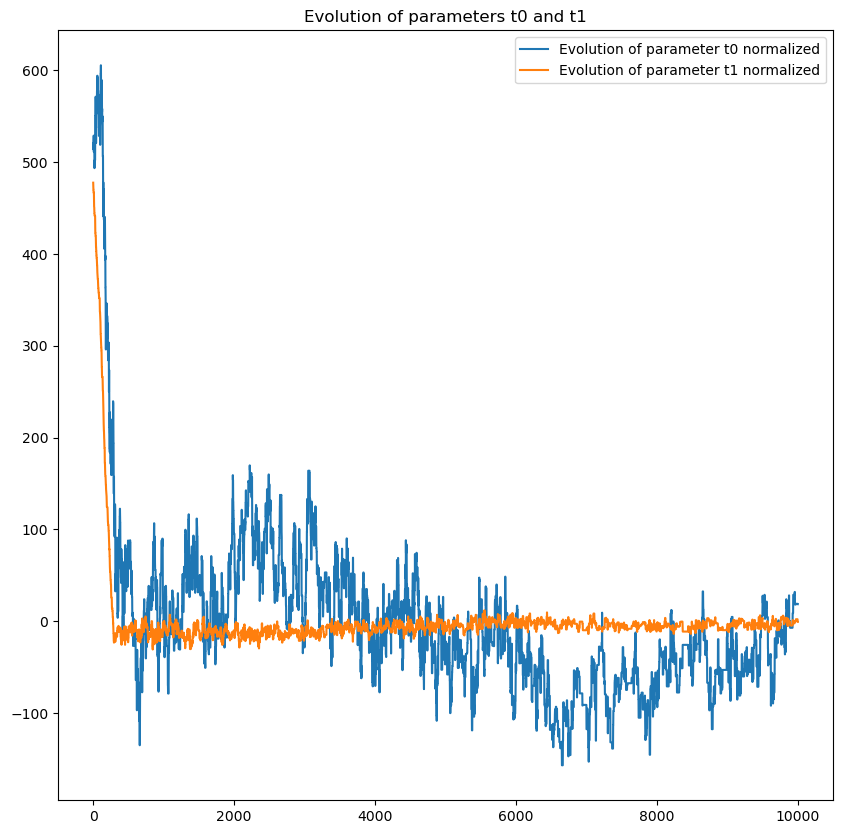

In [69]:
plt.figure(figsize = (10, 10))
plt.plot((Z[:, 0] - np.mean(Z[:, 0])) / np.var(Z[:, 0]) , label = "Evolution of parameter t0 normalized")
plt.plot(( Z[:, 1] - np.mean(Z[:, 1])) / np.var(Z[:, 1]), label = "Evolution of parameter t1 normalized")
plt.title("Evolution of parameters t0 and t1")
plt.legend()
plt.show()

In [68]:
print("Acceptance Rate: ", acceptance_rate)
print("True t0: ", true_t0, "vs Predicted t0: ", z_pred[0])
print("True v0: ", true_v0, "vs Predicted v0: ", z_pred[1])

Acceptance Rate:  0.2352
True t0:  3.7565132152744276 vs Predicted t0:  3.771880422624421
True v0:  13.457436335354652 vs Predicted v0:  13.459553304279456


#### Question 